# Real Estate Data Exploration

I am interested in local real estate markets and how pricing affects sale price, as well as local trends for home size and tax rate. For this exploration I'll be using a dataset of homes sold in 2020 in Glen Ridge, NJ. Columns in the dataframe are address, original list price, final list price, sale price, list date, sale date, square feet, beds, baths, and taxes in 2019. I am interested in analyzing trends such as:
1. Price per square foot by tax brackets
    - I split homes into 10 brackets based on their value as shown by property tax rate. The higher the bracket number, the higher the property tax rate
    - Represented by a faceted bar graph. This will show price per square foot variation within brackets. This visualization is good for counts and comparisons between brackets.
2. List price per square foot vs. sold price per square foot compared to average within tax brackets
    - Represented by a scatterplot with trend line. This shows whether the two values are linearly correlated. 
3. Days on market vs. list price per square foot compared to average within tax brackets
    - I will use this data to explore heat maps 
4. Overall market stats: price, size, beds and baths
    - General stats used to explore other features of the plotting library

# Visualization Library: plotnine

I have heard ggplot2 referenced in this class and through other sources as a well-regarded and easy-to-use visualization package in R. With a little searching I found that plotnine is a Grammar of Graphics approach inspired by ggplot2 and wanted to test it out.

Below is the description from plotnine's website. It was created by Hassan Kibirge.

## *About plotnine*
*History and objective*
plotnine started as an effort to improve the scaling functionality in ggpy formally known as "ggplot for python". It was part of a larger goal to evolve the package into one that supported a full plotting grammar. It turned out that to have a grammar of graphics system we had to just about start anew.*

*The complete guide to what constitutes a "Grammar of Graphics" is Leland Wilkinson's book The Grammar of Graphics. To create ggplot2 Hadley Wickham came up with an interpretation termed A layered grammar of graphics 1. Core to the interpretation is a crucial plot building pipeline 2 in ggplot2 that we adopted 3 for plotnine.*

*The R programming language has a rich statistical ecosystem that ggplot2 taps into with ease. In plotnine we have done our best to integrate with the rest of the scientific python ecosystem. Though we feel we could do more on that integration, notwithstanding language differences, users familiar with ggplot2 should be comfortable and productive with plotnine.*

## *Built with*
*matplotlib - Plotting backend.
pandas - Data handling.
mizani - Scales framework.
statsmodels - For various statistical computations.
scipy - For various statistical computation procedures.*

Source: https://plotnine.readthedocs.io/en/stable/about-plotnine.html

# Demonstration
## Read and clean data
Convert strings to datetime format and create new columns for price per square foot and days on market.

In [1]:
import pandas as pd
from matplotlib import pyplot as plt

#read in data and convert temporal columns to datetime
df=pd.read_csv('Glen_Ridge_Housing_Data.csv')
#calculate price per square foot in new column
df['PPSF']=df['Sale_price']//df['SF']
#pd.to_datetime('7/7/20', format='%m/%d/%y')
#df.loc[16, 'List_date']='4/30/20'
df['List_date']=pd.to_datetime(df['List_date'], format='%m/%d/%y')
#df.loc[16, 'Sale_date']='7/29/20'
#calculate days on market in new column
df['Sale_date']=pd.to_datetime(df['Sale_date'], format='%m/%d/%y')
df['Days_on']=df['Sale_date']-df['List_date']
df.drop(['QV'], axis=1, inplace=True)
df['Days_on']= pd.to_numeric(df['Days_on'].dt.days, downcast='integer')
#convert tax rate to numeric
df['Tax_year_prior_sale']=df['Tax_year_prior_sale'].str.replace(',', '').astype(float)

In [2]:
df.head()

,Address,OLP,FLP,Sale_price,PPSF,List_date,Sale_date,SF,Beds,Full Baths,Half Baths,Tax_year_prior_sale,Days_on
0,132 Linden Ave,529000.0,529000.0,641000.0,370.0,2020-07-15,2020-10-07,1728.0,5.0,1.0,0.0,14120.0,84.0
1,47 Ridgewood Ave,1050000.0,1050000.0,1050000.0,287.0,2020-07-07,2020-09-15,3658.0,6.0,3.0,2.0,27331.0,70.0
2,25 Lincoln St,999000.0,979000.0,989000.0,283.0,2020-07-16,2020-09-11,3488.0,5.0,3.0,2.0,28443.0,57.0
3,87 Douglas Rd,899000.0,899000.0,1110000.0,347.0,2020-07-29,2020-09-11,3195.0,5.0,3.0,2.0,27018.0,44.0
4,495 Ridgewood Ave,999000.0,999000.0,1250000.0,271.0,2020-07-01,2020-09-10,4610.0,5.0,4.0,2.0,39129.0,71.0


Below I will split the data into 10 equal size labels based on tax rate. This way the list price per square foot and sold price per square foot can be compared to the average price per square foot by category, since price per square foot can vary widely across different valuations.

In [3]:
#Split into 10 brackets based on tax rate from 2019
df['Size_label']=pd.qcut(df['Tax_year_prior_sale'], 10, labels=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
df_new = df.groupby(['Size_label']).agg({'PPSF': 'sum', 'Address': 'count'}) 
df_1=pd.merge(df, df_new, on='Size_label')
df_1['Av_PPSF_by_cat']=df_1['PPSF_y']/df_1['Address_y']

df_1['OLP_Diff']=(df_1['OLP']/df_1['SF'])-df_1['Av_PPSF_by_cat']
df_1['Sale_Diff']=(df_1['Sale_price']/df_1['SF'])-df_1['Av_PPSF_by_cat']
df_1.drop(['PPSF_y', 'Address_y'], axis=1, inplace=True)
df_1.dropna(inplace=True)

In [4]:
df_1.head()

,Address_x,OLP,FLP,Sale_price,PPSF_x,List_date,Sale_date,SF,Beds,Full Baths,Half Baths,Tax_year_prior_sale,Days_on,Size_label,Av_PPSF_by_cat,OLP_Diff,Sale_Diff
0,132 Linden Ave,529000.0,529000.0,641000.0,370.0,2020-07-15,2020-10-07,1728.0,5.0,1.0,0.0,14120.0,84.0,1,326.142857,-20.008598,44.806217
1,95 Brighton Ave,499900.0,499900.0,501000.0,333.0,2020-06-01,2020-08-07,1501.0,4.0,1.0,0.0,13443.0,67.0,1,326.142857,6.901780,7.634625
2,154 Essex Ave,549000.0,549000.0,549000.0,351.0,2020-06-03,2020-07-29,1562.0,3.0,1.0,1.0,14797.0,56.0,1,326.142857,25.329614,25.329614
3,14 Clark St,430000.0,380000.0,361000.0,161.0,2019-08-05,2020-03-27,2234.0,3.0,1.0,0.0,13702.0,235.0,1,326.142857,-133.663000,-164.549303
4,74 Stonehouse Rd,509000.0,509000.0,577500.0,460.0,2020-07-12,2020-09-09,1253.0,3.0,1.0,1.0,14908.0,59.0,1,326.142857,80.082203,134.750998


### To install plotnine use the following:

!pip install pandas plotnine

### Import statement:

In [5]:
from plotnine import *
import warnings
warnings.filterwarnings('ignore')

## Basic Plots
Below are examples of a faceted bar chart, scatterplot with trend line, and stacked bar chart. Layering elements is simple with the + operand. The base is a plot which is then layered with one or more geoms. Facet is an additional layer and so are labels. The basic theme is visually pleasing, but can easily be altered as in the third example.

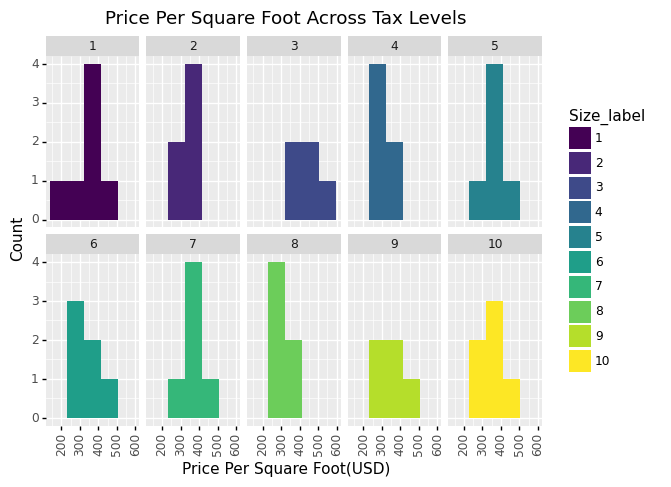

<ggplot: (8774274923984)>

In [6]:
(ggplot(df_1, aes(x='PPSF_x', fill='Size_label')) + 
    geom_histogram(bins=5)  
    + facet_wrap('Size_label', nrow=2)+
    theme(axis_text_x=element_text(rotation=90))+
    labs(x="Price Per Square Foot(USD)", y='Count', 
         title="Price Per Square Foot Across Tax Levels"))




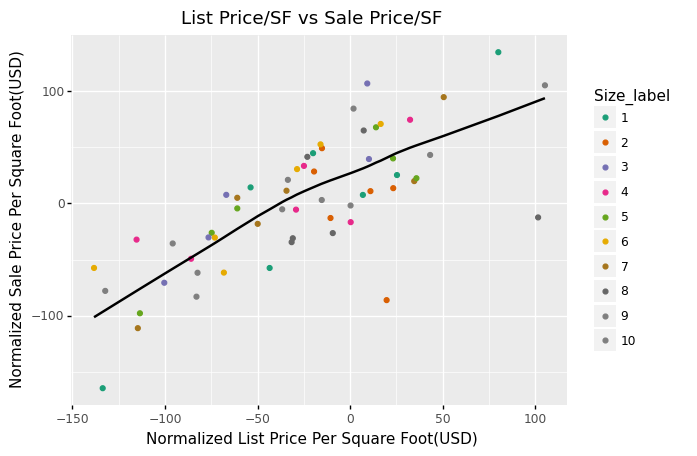

<ggplot: (8774276794811)>

In [7]:
#ggplot(df_1, aes(x='OLP_Diff', y='Sale_Diff', size=50,
   # color = 'Size_label')) + geom_point() 

high_low=pd.DataFrame({'Values': [df_1['Sale_Diff'].max(), df_1['Sale_Diff'].min()]})

ggplot(data=df_1) +\
    geom_point(mapping=aes(x="OLP_Diff", y="Sale_Diff", color='Size_label')) +\
    geom_smooth(mapping=aes(x="OLP_Diff", y="Sale_Diff")) +\
    scale_colour_brewer(type="qual", palette="Dark2") +\
    labs(x="Normalized List Price Per Square Foot(USD)", y='Normalized Sale Price Per Square Foot(USD)', 
         title="List Price/SF vs Sale Price/SF")
      

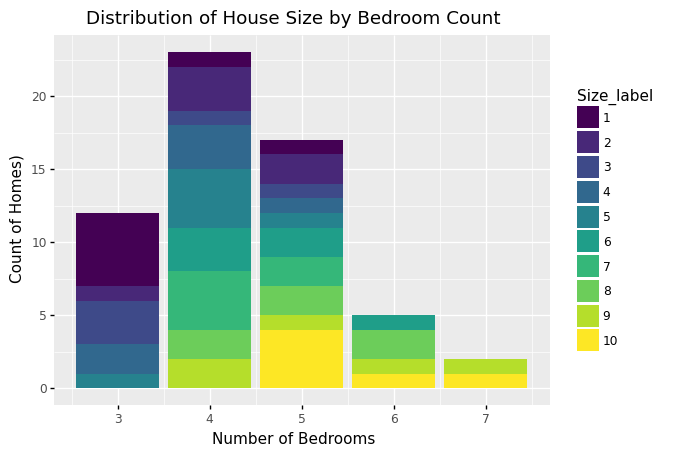

<ggplot: (8774274923972)>

In [8]:
ggplot(df_1, aes(x='Beds', fill = 'Size_label')) + \
    geom_bar(stat = 'count') +\
    labs(x="Number of Bedrooms", y='Count of Homes)', 
         title="Distribution of House Size by Bedroom Count")

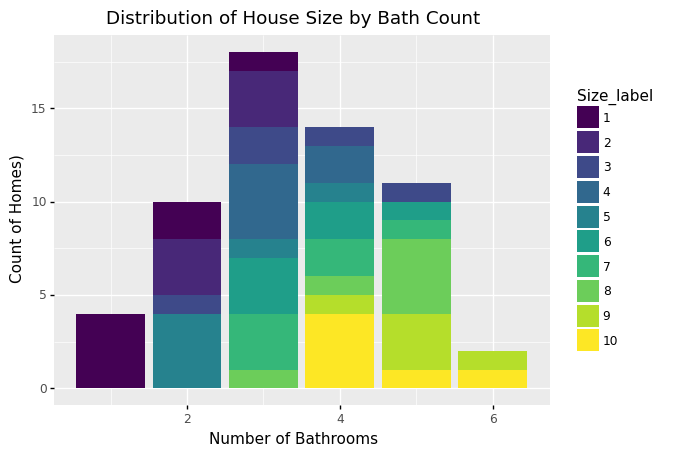

<ggplot: (8774277122244)>

In [9]:
df_1['Baths']= df_1['Full Baths']+ df_1['Half Baths']
ggplot(df_1, aes(x='Baths', fill = 'Size_label')) + \
    geom_bar(stat = 'count') +\
    labs(x="Number of Bathrooms", y='Count of Homes)', 
         title="Distribution of House Size by Bath Count")

As expected, homes with a higher value (based on property tax category) tend towards more bedrooms and bathrooms. Let's look at both of those features together in a heat map.

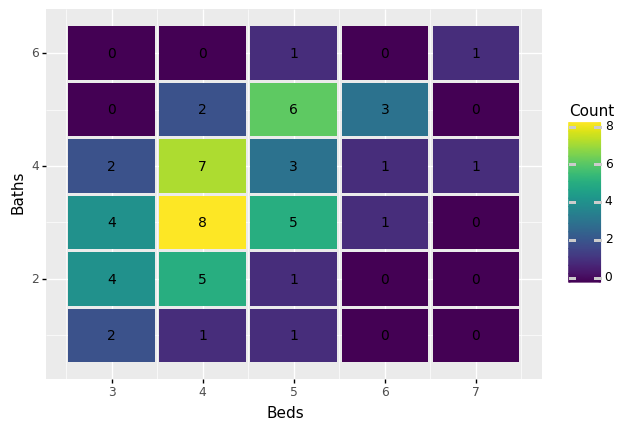

<ggplot: (8774277385096)>

In [10]:
df_bb=df_1[['Beds', 'Baths']]
counts=pd.crosstab(df_bb.Beds,df_bb.Baths)
counts=counts.stack().reset_index()
counts.rename(columns={ counts.columns[2]: "Count" }, inplace = True)

ggplot(counts, aes('Beds', 'Baths', fill='Count')) +\
  geom_tile(aes(width=.95, height=.95)) +\
  geom_text(aes(label='Count'), size=10)


I'll use a violin plot to show the distribution of sale price within property tax categories. The most expensive category (10) has the largest distribution.

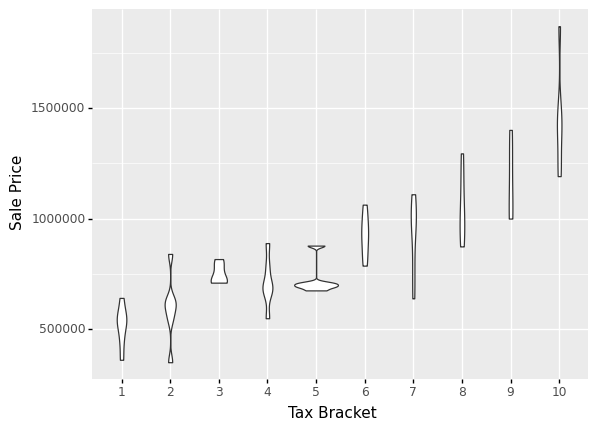

<ggplot: (8774277171613)>

In [11]:
(
    ggplot(df_1, aes(x='Size_label', y='Sale_price'))
    + geom_violin()
    + xlab('Tax Bracket')
    + ylab('Sale Price')
)

I'd like to revisit the scatterplot of list price per square foot vs. sale price per square foot. There was no distinguishable pattern within categories. Let's try splitting the homes into three brackets: small, medium, and large. This will again be based on tax rate. Perhaps it will reveal general trends by value.

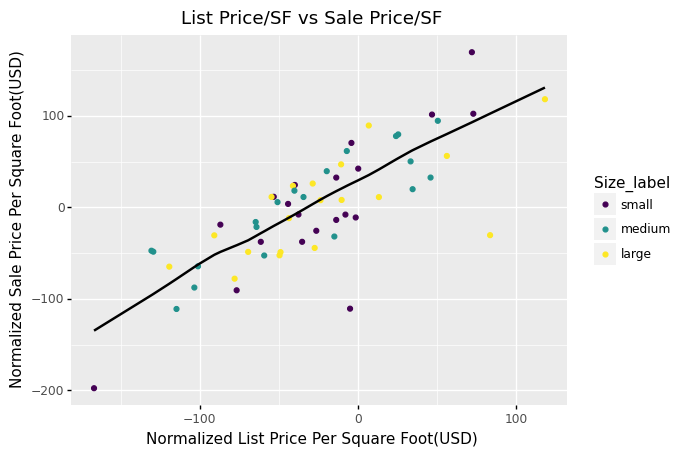

<ggplot: (8774274958168)>

In [12]:
df['Size_label']=pd.qcut(df['Tax_year_prior_sale'], 3, labels=["small", "medium","large"])
df_new = df.groupby(['Size_label']).agg({'PPSF': 'sum', 'Address': 'count'}) 
df_1=pd.merge(df, df_new, on='Size_label')
df_1['Av_PPSF_by_cat']=df_1['PPSF_y']/df_1['Address_y']

df_1['OLP_Diff']=(df_1['OLP']/df_1['SF'])-df_1['Av_PPSF_by_cat']
df_1['Sale_Diff']=(df_1['Sale_price']/df_1['SF'])-df_1['Av_PPSF_by_cat']
df_1.drop(['PPSF_y', 'Address_y'], axis=1, inplace=True)
df_1.dropna(inplace=True)

ggplot(data=df_1) +\
    geom_point(mapping=aes(x="OLP_Diff", y="Sale_Diff", color='Size_label')) +\
    geom_smooth(mapping=aes(x="OLP_Diff", y="Sale_Diff")) +\
    labs(x="Normalized List Price Per Square Foot(USD)", y='Normalized Sale Price Per Square Foot(USD)', 
         title="List Price/SF vs Sale Price/SF")

The linear trend appears to hold for all three categories.

Overall, plotnine is simple to use. The downside is that there isn't as much documentation or examples for this library as there is for others like Altair or Seaborn.

**Sources:** 
- https://monashdatafluency.github.io/python-workshop-base/modules/plotting_with_ggplot/
- https://datascienceworkshops.com/blog/plotnine-grammar-of-graphics-for-python/
- https://plotnine.readthedocs.io/en/stable/#
